## construct dataframe

In [1]:
import pandas as pd
import os
import json

path = "/home/liwei/workspace/GECProject/fangzheng_v2/bert-augment-1130-test1129.txt"
src_path = "/home/liwei/workspace/datasets/FangZhengTest/test_1129.json"

with open(src_path, 'r') as f:
    src_data = json.load(f)

sentences = {"src": [], "tgt": [], "predict": [], "type": [], "wrong_syntactics": [], "distance": [], 
            "correct_w_collocation_times": [], "wrong_w_collocation_times": [], "correct_w_frequency": [], "wrong_w_frequency": [], "collocation_type": []}
with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f.readlines()):
        lines = line.replace("\n", '').split("\t")
        if len(lines[0]) != len(lines[1]) or len(lines[1]) != len(lines[2]):
            print(line)
        sentences["src"].append(lines[0])
        sentences["tgt"].append(lines[1])
        sentences["predict"].append(lines[2])

        if lines[2] == lines[0]:
            sentences["type"].append("未更改")
        elif lines[1] == lines[2]:
            sentences["type"].append("修改正确")
        else:
            sentences["type"].append("修改错误")
        
        assert lines[0] == src_data[i]["text"], '\n' + lines[0] + '\n' + src_data[i]["text"]

        for key in sentences.keys():
            if key not in ["src", "tgt", "predict", "type"]:
                sentences[key].append(src_data[i]["wrong"][key])

dir = os.path.dirname(path)
df = pd.DataFrame(sentences)
df.to_excel(os.path.join(dir, "cases.xlsx"), index=False)

In [2]:
df_correct = df[df["type"] == "修改正确"]
df_wrong = df[(df["type"] == "修改错误") | (df["type"] == "未更改")]
df_error = df[df["type"] == "修改错误"]
df_unchanged = df[df["type"] == "未更改"]

df_map = {"正确": df_correct, "错误": df_wrong, "修改错误": df_error, "未更改": df_unchanged}

In [3]:
df.columns

Index(['src', 'tgt', 'predict', 'type', 'wrong_syntactics', 'distance',
       'correct_w_collocation_times', 'wrong_w_collocation_times',
       'correct_w_frequency', 'wrong_w_frequency', 'collocation_type'],
      dtype='object')

In [4]:
from collections import Counter

dict(Counter(df['type'].tolist()))

{'未更改': 144, '修改正确': 52, '修改错误': 75}

In [5]:
def count_for_different_df(key, types: list[str]):
    global df
    dfs = [df_map[t] for t in types]
    all_res = {"class": [], "num": [], "type": []}
    all_classes = list(dict(Counter(df[key].to_list())).keys())
    for i, dataframe in enumerate(dfs):
        part_res = dict(Counter(dataframe[key].to_list()))
        for class_ in all_classes:
            all_res["class"].append(class_)
            all_res["type"].append(types[i])
            if class_ in part_res:
                all_res["num"].append(part_res[class_] / len(dataframe))
            else:
                all_res["num"].append(0)
    return all_res

In [6]:
count_for_different_df('wrong_syntactics', ["正确", "错误"])

{'class': ['谓语错误',
  '定语错误',
  '动词错误',
  '宾语错误',
  '中心语错误',
  '主语错误',
  '谓语错误',
  '定语错误',
  '动词错误',
  '宾语错误',
  '中心语错误',
  '主语错误'],
 'num': [0.1346153846153846,
  0.15384615384615385,
  0.5,
  0.07692307692307693,
  0.1346153846153846,
  0,
  0.0867579908675799,
  0.1187214611872146,
  0.547945205479452,
  0.1141552511415525,
  0.1050228310502283,
  0.0273972602739726],
 'type': ['正确',
  '正确',
  '正确',
  '正确',
  '正确',
  '正确',
  '错误',
  '错误',
  '错误',
  '错误',
  '错误',
  '错误']}

## 可视化

In [7]:
import seaborn as sns
# import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False  # Solve the minus sign problems
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
import matplotlib
print(matplotlib.get_cachedir())
print(matplotlib.matplotlib_fname())
import matplotlib.pyplot as plt
plt.figure(dpi=200)

/home/liwei/.cache/matplotlib
/home/liwei/workspace/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

### 错误的句法成分

<AxesSubplot: >

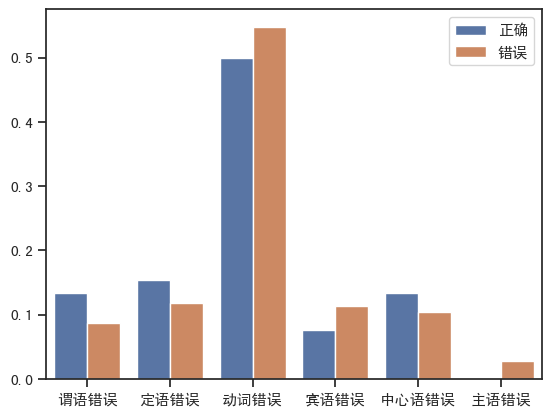

In [8]:
res = count_for_different_df('wrong_syntactics', ["正确", "错误"])
sns.barplot(x="class", y="num", hue="type", data=res)

<AxesSubplot: >

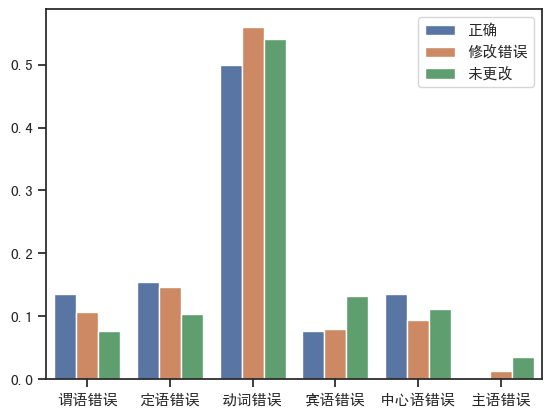

In [9]:
res = count_for_different_df('wrong_syntactics', ["正确", "修改错误", "未更改"])
sns.barplot(x="class", y="num", hue="type", data=res)

### 搭配类型

<AxesSubplot: >

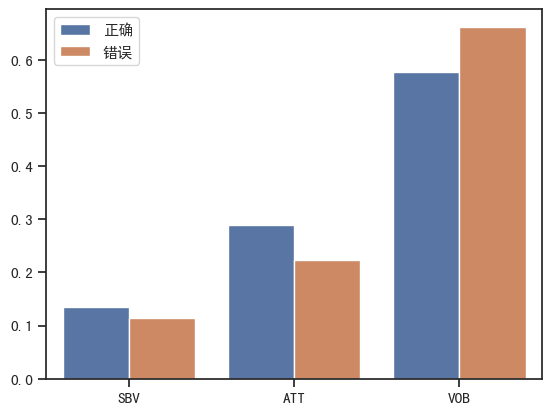

In [10]:
res = count_for_different_df('collocation_type', ["正确", "错误"])
sns.barplot(x="class", y="num", hue="type", data=res)

<AxesSubplot: >

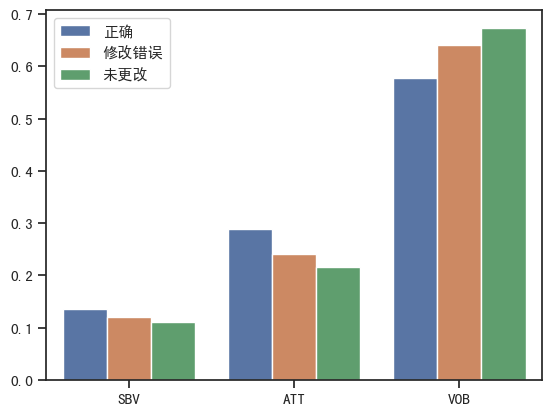

In [11]:
res = count_for_different_df('collocation_type', ["正确", "修改错误", "未更改"])
sns.barplot(x="class", y="num", hue="type", data=res)

### 数值项目

In [12]:
features = [('distance', '搭配词距离'), ('correct_w_collocation_times', '正词搭配次数'), ('wrong_w_collocation_times', '错词搭配次数'),
       ('correct_w_frequency', '正词词频'), ('wrong_w_frequency', '错词词频')]

In [13]:
import numpy as np
mean_features = {}
for feature_key_name, feature_name in features:
    mean_features[feature_key_name] = np.mean([float(it) for it in df[feature_key_name].tolist()])

res = {'class': [], 'value': [], 'type': []}
for i, item in df.iterrows():
    for feature_key_name, feature_name in features:
        res['class'].append(feature_name)
        res['value'].append(item[feature_key_name] / mean_features[feature_key_name])
        res['type'].append(item['type'])

<AxesSubplot: >

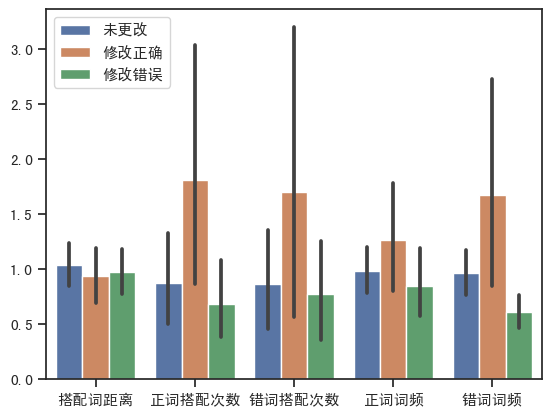

In [14]:
sns.barplot(x="class", y="value", hue="type", data=res)